<a href="https://colab.research.google.com/github/castudil/som-lstm/blob/main/algoritmo_perturbacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

# Funcion de Perturbacion



In [2]:
iris = sns.load_dataset("iris")


In [142]:
def perturbation(df, col=0, mu=0, sigma=0.1):

  """
    Funcion que perturba una columna de un dataframe, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
        df : DataFrame 
          DataFrame de los datos para perturbar
        col : int
          columna del DataFrame que sera perturbada
        mu: float
          mean
        sigma: float
          desviacion estandar
  """
  df = df.copy() # copia el dataframe para evitar que se modifique el dataframe original

  cardinality = df.shape[0] # numero de instancias del dataset

  # Toma muestras aleatorias de una distribución normal
  perturbacion = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))

  columns_name  = df.columns # nombres de las columnas

  # Suma las muestras aleatorias a la columna seleccionada y pasa esta suma al dataset copiado.
  df[columns_name[col]] = df[columns_name[col]] + perturbacion  

  return df

## Test de perturbaciones 

In [4]:
p1 = perturbation(df=iris, col=0)

print(p1.head())
print(iris.head())



   sepal_length  sepal_width  petal_length  petal_width species
0      4.964164          3.5           1.4          0.2  setosa
1      4.777564          3.0           1.4          0.2  setosa
2      4.691586          3.2           1.3          0.2  setosa
3      4.636108          3.1           1.5          0.2  setosa
4      4.985824          3.6           1.4          0.2  setosa
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [5]:
p2 = perturbation(iris, col=3)

print(p2.head())
print(iris.head())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4     0.194136  setosa
1           4.9          3.0           1.4     0.088625  setosa
2           4.7          3.2           1.3     0.206258  setosa
3           4.6          3.1           1.5     0.163317  setosa
4           5.0          3.6           1.4     0.054001  setosa
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


# Modelos

## Cargar dataset

In [60]:
path = 'https://raw.githubusercontent.com/castudil/som-lstm/main/data/talca.csv' # use your path

df = pd.read_csv(path, index_col=None, header=0)
# Convert the date column to a datestamp type
df['date'] = pd.to_datetime(df['date'])
# Set the date column as the index of your DataFrame meat
df = df.set_index('date')

print(df.sample(5))

print(df.describe())


                        PM25
date                        
2018-04-11 13:00:00    1.000
2019-02-16 13:00:00    5.000
2019-07-26 15:00:00   20.000
2017-01-27 19:00:00  277.000
2016-02-15 07:00:00    7.842
               PM25
count  43847.000000
mean      16.653470
std       27.244984
min        0.000000
25%        3.000000
50%        8.000000
75%       19.000000
max      766.200000


#SVR

In [96]:
from sklearn.svm import SVR 
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
import tensorflow as tf



In [119]:
def get_data(df):  
    data = df.copy()

    test = data.loc['2016-07-1':'2016-07-31'].resample('D').mean()
    train = data.loc['2016-04-1': '2016-06-30'].resample('D').mean()

    x_train = range(0, train.shape[0])
    x_train = np.reshape(x_train,(len(x_train), 1))
    y_train = train['PM25'].tolist()

    x_test = range( train.shape[0],  train.shape[0]+test.shape[0])
    x_test = np.reshape(x_test,(len(x_test), 1))
    y_test = test['PM25'].tolist()


    return [x_train, y_train, x_test, y_test] 

In [147]:
x_train, y_train, x_test, y_test = get_data(df)

print(x_train.shape, len(y_train))
print(x_test.shape, len(y_test))


(91, 1) 91
(31, 1) 31


In [121]:
def evaluate_model( predict, y_test):

  rmse = tf.keras.metrics.RootMeanSquaredError()
  rmse.update_state(y_test, predict)

  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state(y_test, predict)

  mse = tf.keras.metrics.MeanSquaredError()
  mse.update_state(y_test, predict)

  #rmse_sent = math.sqrt(mean_squared_error(testY_inverse, simple_pred))
  print ('Test MSE: %.3f' %  mse.result().numpy())
  print ('Test RMSE: %.3f' % rmse.result().numpy())
  print ('Test MAE: %.3f' %  mae.result().numpy())
  print ("")

In [111]:
def predict_prices(x_train, y_train, x_test, y_test):
    
    svr_lin  = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

    # Fit regression model
    svr_lin .fit(x_train, y_train)
    svr_poly.fit(x_train, y_train)
    svr_rbf.fit(x_train, y_train)

    plt.scatter(x_train, y_train, c='k', label='Data')
    plt.plot(x_train, svr_lin.predict(x_train), c='g', label='Linear model')
    plt.plot(x_train, svr_rbf.predict(x_train), c='r', label='RBF model')    
    plt.plot(x_train, svr_poly.predict(x_train), c='b', label='Polynomial model')
    
    
    plt.xlabel('Date')
    plt.ylabel('PM25')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()

    print('SVR-RBF\n')
    rbf_predict = svr_rbf.predict(x_test)
    evaluate_model(rbf_predict, y_test)

    print('SVR-LIN\n')
    lin_predict = svr_lin.predict(x_test)
    evaluate_model(lin_predict, y_test)

    print('SVR-POLY\n')
    poly_predict = svr_poly.predict(x_test)
    evaluate_model(poly_predict, y_test)

    plt.scatter(x_test, y_test, c='y', label='Data test')
    plt.plot(x_test, lin_predict, c='g', label='Linear model')
    plt.plot(x_test, rbf_predict, c='r', label='RBF model')    
    plt.plot(x_test, poly_predict, c='b', label='Polynomial model')
    plt.xlabel('Date')
    plt.ylabel('PM25')
    plt.title('Support Vector Regression (Prediction)')
    plt.legend()
    plt.show()
    


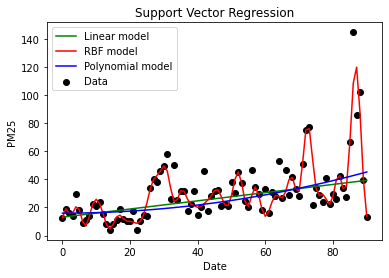

SVR-RBF

Test MSE: 494.804
Test RMSE: 22.244
Test MAE: 18.136

SVR-LIN

Test MSE: 503.422
Test RMSE: 22.437
Test MAE: 18.081

SVR-POLY

Test MSE: 878.163
Test RMSE: 29.634
Test MAE: 25.064



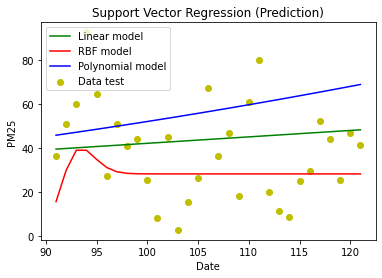

In [122]:
predict_prices(x_train, y_train, x_test, y_test)

# Model con dataset perturbado

In [144]:
copia_df = df.copy()
copia_df = copia_df.reset_index()
print(copia.head())

data_p = perturbation(df=copia_df, col=1)

data_p.head()



                 date    PM25
0 2016-01-01 01:00:00  11.980
1 2016-01-01 02:00:00   7.986
2 2016-01-01 03:00:00   3.993
3 2016-01-01 04:00:00   5.324
4 2016-01-01 05:00:00   5.240


,date,PM25
0,2016-01-01 01:00:00,11.943208
1,2016-01-01 02:00:00,8.052539
2,2016-01-01 03:00:00,3.875268
3,2016-01-01 04:00:00,5.376938
4,2016-01-01 05:00:00,5.314990


In [148]:
x_trainP, y_trainP, x_testP, y_testP = get_data(data_p.set_index('date'))

print(x_trainP.shape, len(y_trainP))
print(x_testP.shape, len(y_testP))



(91, 1) 91
(31, 1) 31


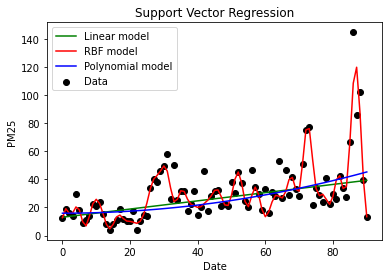

SVR-RBF

Test MSE: 494.885
Test RMSE: 22.246
Test MAE: 18.137

SVR-LIN

Test MSE: 503.511
Test RMSE: 22.439
Test MAE: 18.086

SVR-POLY

Test MSE: 880.086
Test RMSE: 29.666
Test MAE: 25.091



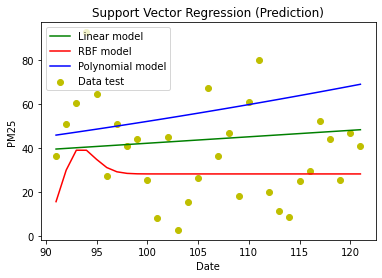

In [151]:
predict_prices(x_trainP, y_trainP, x_testP, y_testP)